In [1]:
import os
import base64
import glob
import json
import typing as t
import zlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pycocotools import _mask as coco_mask
from scipy import ndimage
from scipy.ndimage import label
from skimage.morphology import opening, remove_small_objects, square
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import backend as K, callbacks
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Conv2D, Dropout, Input, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Setup paths and import all the necessary data for train and test
# if using outside of kaggle, change path to where you downloaded the data set, for me i used colab and google drive to host the datasets
train_path = "/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-the-Human-Vasculature/Dataset/Data/train/*"
test_path = "/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-the-Human-Vasculature/Dataset/Data/test/*"

train = glob.glob(train_path)
test = glob.glob(test_path)

# Create a dictionary to hold the annotations for each image
annotations = {}

# Open the annotations file
with open("/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-the-Human-Vasculature/Dataset/Data/polygons.jsonl", 'r') as f:
    # For each line in the file
    for line in f:
        # Parse the line as JSON
        annotation = json.loads(line)

        # Get the image ID and the list of annotations for this image
        image_id = annotation['id']
        image_annotations = annotation['annotations']

        # Store the annotations in the dictionary
        annotations[image_id] = image_annotations
        
# Create our image map for our train data and test data
image_map = {impath.split('/')[-1].split('.')[0]: impath for impath in train}
image_map_test = {impath.split('/')[-1].split('.')[0]: impath for impath in test}

In [4]:
print(image_map_test)

{'72e40acccadf': '/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-the-Human-Vasculature/Dataset/Data/test/72e40acccadf.tif'}


In [5]:
def convert_to_mask(annotations):
    """
    Converts annotations to a binary mask.

    Parameters:
    - annotations: A list of annotations for a single image.

    Returns:
    - mask: The binary mask.
    """
    # Set the image dimensions directly
    image_dimensions = (512, 512)
    
    # Create an empty mask of the same size as the image
    mask = np.zeros(image_dimensions, dtype=np.uint8)

    # For each annotation
    for annotation in annotations:
        coordinates = np.array(annotation['coordinates'])
        coordinates = coordinates.reshape(-1, 1, 2)
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [coordinates], 255)

    return mask

In [6]:
# create data frame, mapping our image file paths to the correct annotation
# Initialize an empty list to hold the DataFrame data
df_data = []

for image_id, image_path in image_map.items():
    # get only annotations that have a matching image id
    annotation = annotations.get(image_id)
    
    if annotation:  # If annotations for this image exist
        # Filtering out unnecessary annotation types and only keeping 'blood_vessel'
        blood_vessel_annotations = [an for an in annotation if an['type'] == 'blood_vessel']

        if blood_vessel_annotations:
            # Convert these annotations to a binary mask
            mask = convert_to_mask(blood_vessel_annotations)
            df_data.append([image_id, image_path, mask])

# Convert list of dictionaries to a DataFrame
df = pd.DataFrame(df_data, columns=['id', 'filepath', 'mask'])

In [7]:
# ImageDataGenerator requires a file path in order to use our binary mask, 
# so we need to save our masks as .png and replace their values with the path to the saved mask
# Create the directory if it doesn't exist
os.makedirs('/masks', exist_ok=True)
# Iterate through the DataFrame and save masks
for idx, row in df.iterrows():
    mask_array = row['mask']  # assuming this is your binary mask array
    mask_img = Image.fromarray((mask_array * 255).astype(np.uint8))  # convert to an image
    filepath = f"/masks/{row['id']}.png"  # specify file path
    mask_img.save(filepath)
    df.at[idx, 'mask'] = filepath  # update mask value with file path

In [8]:
# Display the DataFrame
df.head()

,id,filepath,mask
0,dad151b200fe,/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-t...,/masks/dad151b200fe.png
1,daf9beac4413,/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-t...,/masks/daf9beac4413.png
2,db03a1487798,/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-t...,/masks/db03a1487798.png
3,db04612e2648,/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-t...,/masks/db04612e2648.png
4,db20b95a3ab9,/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-t...,/masks/db20b95a3ab9.png


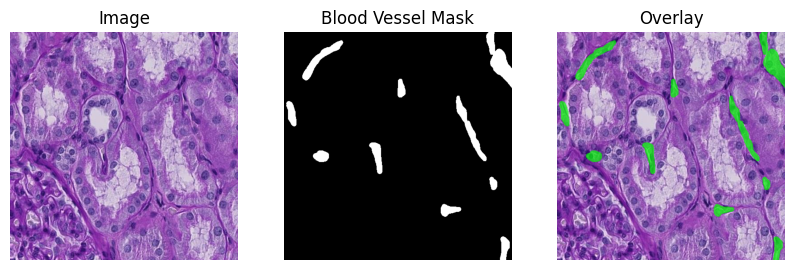

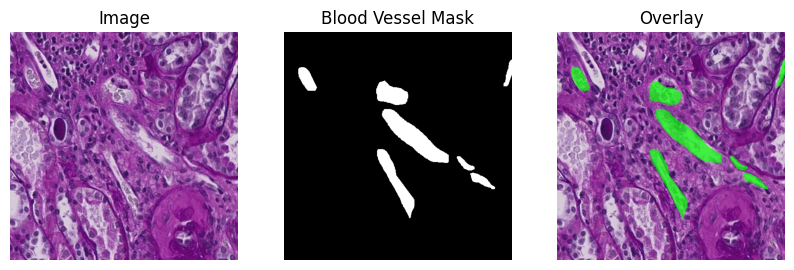

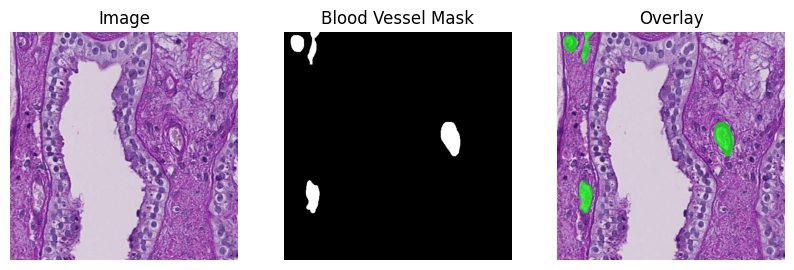

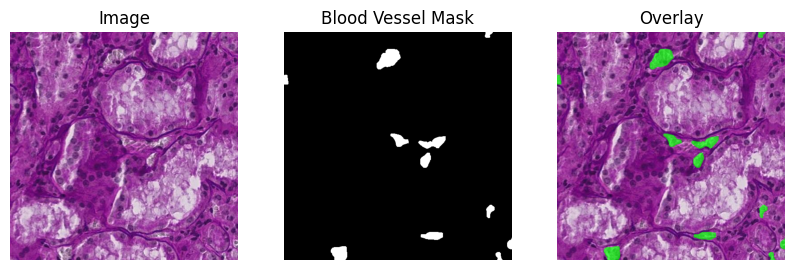

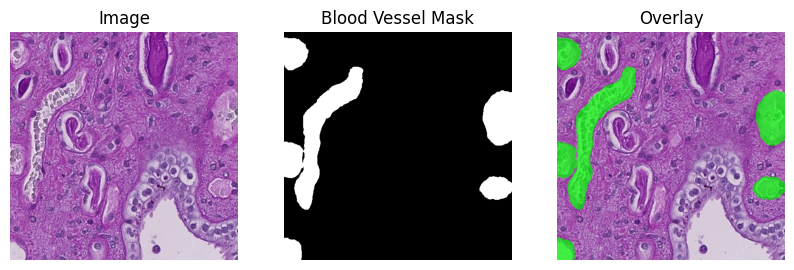

In [9]:
# Display the first 5 images and masks
for i in range(5):
    # Load image
    img = cv2.imread(df.iloc[i]['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR color order

    # Load mask
    mask = cv2.imread(df.iloc[i]['mask'], cv2.IMREAD_GRAYSCALE)

    # Create overlay image
    overlay = img.copy()
    overlay[mask > 0] =  (0, 255, 0)

    # Display image and mask
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].axis('off')  # Turn off axis for image
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Blood Vessel Mask')
    ax[1].axis('off')  # Turn off axis for mask
    ax[2].imshow(img)
    ax[2].imshow(overlay, alpha=0.7)
    ax[2].set_title('Overlay')
    ax[2].axis('off')  # Turn off axis for mask

plt.show()

In [10]:
def my_preprocessing_func(img):
    # Normalization (assuming the image is in uint8 format)
    img = img / 255.0
    return img

In [11]:
# Specify data augmentation parameters
data_gen_args = dict(rotation_range=15.,
                     width_shift_range=0.15,
                     height_shift_range=0.15,
                     shear_range=0.15,
                     zoom_range=0.15,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Create ImageDataGenerator with augmentation and preprocessing for images
image_datagen = ImageDataGenerator(
    preprocessing_function=my_preprocessing_func,
    **data_gen_args  # use the same augmentations for images
)

# Create ImageDataGenerator with augmentation for masks
mask_datagen = ImageDataGenerator(
    **data_gen_args  # use the same augmentations for masks
)

# Provide the same seed and keyword arguments to the fit and flow methods for reproducibility
seed = 1
# Define batch size
batch_size=8

# SplitDataFrame `df` with 'filepath' and 'mask' columns
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% for train and 20% for validation

# get number of train samples for training the model (used for epoch_steps)
total_train_samples =len(train_df)

# get number of val samples for training the model (used for epoch_steps)
total_val_samples =len(val_df)

# Flow from dataframe method for training data
image_generator_train = image_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    class_mode=None,
    color_mode="rgb",  
    target_size=(512, 512),  
    batch_size=batch_size,
    seed=seed)

mask_generator_train = mask_datagen.flow_from_dataframe(
    train_df,
    x_col="mask",
    class_mode=None,
    color_mode="grayscale",
    target_size=(512, 512),
    batch_size=batch_size,
    seed=seed)

# Combine generators into one which yields image and mask for training data
train_generator = zip(image_generator_train, mask_generator_train)

# Flow from dataframe method for validation data
image_generator_val = image_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    class_mode=None,
    color_mode="rgb",  
    target_size=(512, 512),  
    batch_size=batch_size,
    seed=seed)

mask_generator_val = mask_datagen.flow_from_dataframe(
    val_df,
    x_col="mask",
    class_mode=None,
    color_mode="grayscale",
    target_size=(512, 512),
    batch_size=batch_size,
    seed=seed)

# Combine generators into one which yields image and mask for validation data
val_generator = zip(image_generator_val, mask_generator_val)

Found 1284 validated image filenames.
Found 1284 validated image filenames.
Found 321 validated image filenames.
Found 321 validated image filenames.


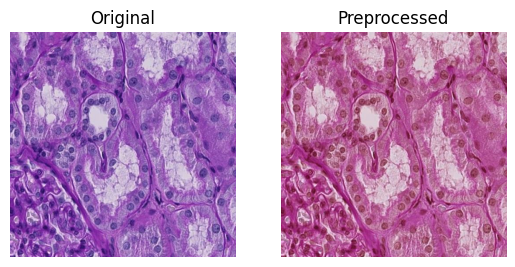

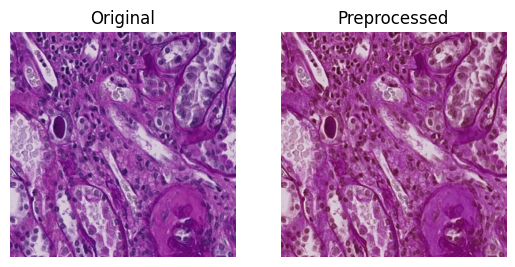

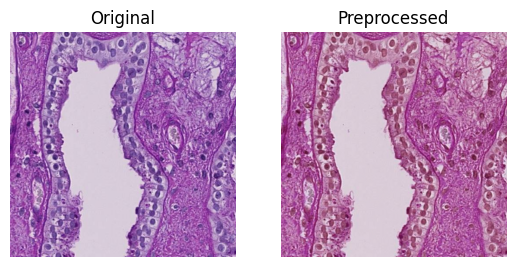

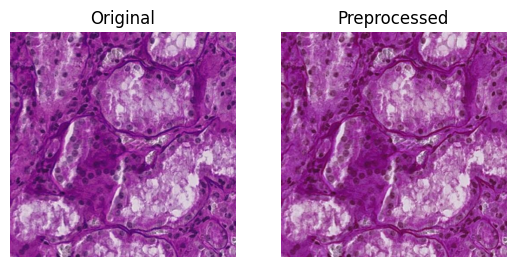

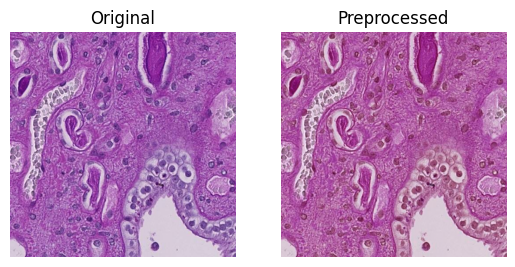

In [12]:
# Select the first five images
first_five_images = df['filepath'].values[:5]

for image_path in first_five_images:
    # Load the image
    img = cv2.imread(image_path)
    
    # Apply the preprocessing function
    preprocessed_img = my_preprocessing_func(img)
    
    # Display the original and preprocessed images
    fig, axes = plt.subplots(1, 2)
    
    # Original image
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Preprocessed image
    axes[1].imshow(preprocessed_img, cmap='gray' if len(preprocessed_img.shape)==2 else None)
    axes[1].set_title('Preprocessed')
    axes[1].axis('off')
    
    plt.show()

In [13]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

In [14]:

def create_model(input_shape):

    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

    encoder1 = Model(base_model.input, base_model.get_layer('block1b_add').output)  # 256x256
    encoder2 = Model(base_model.input, base_model.get_layer('block2b_add').output)  # 128x128
    encoder3 = Model(base_model.input, base_model.get_layer('block3b_add').output)  # 64x64
    encoder4 = Model(base_model.input, base_model.get_layer('block5b_add').output)  # 32x32
    encoder5 = Model(base_model.input, base_model.get_layer('block7b_add').output)  # 16x16

    # Define the layers for the decoder path
    center = Conv2D(2048, (3, 3), padding='same')(encoder5.output)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Dropout(0.35)(center)
    center = Conv2D(2048, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Dropout(0.35)(center)

    # Decoder path
    decoder4 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(center)
    decoder4 = concatenate([decoder4, encoder4.output])
    decoder4 = Conv2D(1024, (3, 3), padding='same')(decoder4)
    decoder4 = BatchNormalization()(decoder4)
    decoder4 = Activation('relu')(decoder4)
    decoder4 = Dropout(0.35)(decoder4)
    decoder4 = Conv2D(1024, (3, 3), padding='same')(decoder4)
    decoder4 = BatchNormalization()(decoder4)
    decoder4 = Activation('relu')(decoder4)
    decoder4 = Dropout(0.35)(decoder4)
    
    decoder3 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(decoder4)
    decoder3 = concatenate([decoder3, encoder3.output])
    decoder3 = Conv2D(512, (3, 3), padding='same')(decoder3)
    decoder3 = BatchNormalization()(decoder3)
    decoder3 = Activation('relu')(decoder3)
    decoder3 = Dropout(0.35)(decoder3)
    decoder3 = Conv2D(512, (3, 3), padding='same')(decoder3)
    decoder3 = BatchNormalization()(decoder3)
    decoder3 = Activation('relu')(decoder3)
    decoder3 = Dropout(0.35)(decoder3)
    
    decoder2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(decoder3)
    decoder2 = concatenate([decoder2, encoder2.output])
    decoder2 = Conv2D(256, (3, 3), padding='same')(decoder2)
    decoder2 = BatchNormalization()(decoder2)
    decoder2 = Activation('relu')(decoder2)
    decoder2 = Dropout(0.35)(decoder2)
    decoder2 = Conv2D(256, (3, 3), padding='same')(decoder2)
    decoder2 = BatchNormalization()(decoder2)
    decoder2 = Activation('relu')(decoder2)
    decoder2 = Dropout(0.35)(decoder2)
    
    decoder1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(decoder2)
    decoder1 = concatenate([decoder1, encoder1.output])
    decoder1 = Conv2D(128, (3, 3),padding='same')(decoder1)
    decoder1 = BatchNormalization()(decoder1)
    decoder1 = Activation('relu')(decoder1)
    decoder1 = Dropout(0.35)(decoder1)
    decoder1 = Conv2D(128, (3, 3),padding='same')(decoder1)
    decoder1 = BatchNormalization()(decoder1)
    decoder1 = Activation('relu')(decoder1)
    decoder1 = Dropout(0.35)(decoder1)

    # Added an extra upsampling step to match the input size
    decoder0 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(decoder1)
    decoder0 = Conv2D(64, (3, 3), padding='same')(decoder0)
    decoder0 = BatchNormalization()(decoder0)
    decoder0 = Activation('relu')(decoder0)
    decoder0 = Dropout(0.35)(decoder0)
    decoder0 = Conv2D(64, (3, 3), padding='same')(decoder0)
    decoder0 = BatchNormalization()(decoder0)
    decoder0 = Activation('relu')(decoder0)
    decoder0 = Dropout(0.35)(decoder0)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    
    # Create the model
    model = Model(inputs=[base_model.input], outputs=[outputs])
    return model

In [15]:
# define our dice_coef and loss functions
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
def combined_dice_bce_loss(y_true, y_pred, weight=0.5):
    dice_loss_value = dice_loss(y_true, y_pred)
    bce_loss_value = binary_crossentropy(y_true, y_pred)
    return weight * bce_loss_value + (1 - weight) * dice_loss_value
def IoU(y_true, y_pred):
    y_true = K.cast(K.greater(y_true, 0.5), dtype='float32') # thresholding at 0.5
    y_pred = K.cast(K.greater(y_pred, 0.5), dtype='float32') # thresholding at 0.5
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return intersection / union

In [16]:
# Creat the Model
model = create_model(input_shape=(512, 512, 3))  # assuming your images are 512x512 pixels with 3 color channels
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_dice_bce_loss, metrics=[dice_coef,IoU])

71686520/71686520 [==============================] - 3s 0us/step


In [17]:
# Define callbacks for early stopping and learning rate schedule
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', # choose the metric to monitor
    patience=10, # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # whether to restore model weights from the epoch with the best monitored metric.
)

# Define callback for learning rate schedule
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_schedule = callbacks.LearningRateScheduler(scheduler)

In [18]:
# Create a dummy input with the same shape as your actual input
dummy_input = np.random.random((1, 512, 512, 3))

# Run the dummy input through your model
dummy_output = model.predict(dummy_input)

# Print the shape of the dummy output
print(dummy_output.shape)

1/1 [==============================] - 14s 14s/step
(1, 512, 512, 1)


In [19]:
# Train the model with the callbacks
history = model.fit(
    train_generator,
    steps_per_epoch= total_train_samples // batch_size,  # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    epochs=100,
    validation_data=val_generator,  # it should be validation_data not val_generator
    validation_steps= total_val_samples // batch_size,   # Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/100


ResourceExhaustedError: ignored

In [ ]:
model.save('/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-the-Human-Vasculature/model-Final-smallRes152V2.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/Kaggle/HuBMAP-Hacking-the-Human-Vasculature/model-Final-largeEfficenetB4_weights.h5')

In [ ]:
def process_mask(predicted_mask, selem_size=3, min_size=100):
    """
    Perform morphological operations and small object removal on the predicted mask.

    Args:
    predicted_mask (numpy.ndarray): The predicted mask.
    selem_size (int, optional): The size of the structure element for morphological operations. Default is 3.
    min_size (int, optional): The minimum size of the objects to be retained. Default is 100.

    Returns:
    final_mask (numpy.ndarray): The processed mask.
    """

    # Ensure that the input is a 2D array
    if len(predicted_mask.shape) > 2:
        predicted_mask = predicted_mask.squeeze()
    # Create structure element
    selem = square(selem_size)

    # Perform morphological operation (opening)
    opened_mask = opening(predicted_mask, selem)

    # Label connected components
    labeled_array, num_features = ndimage.label(opened_mask)

    # Create an empty mask to hold the remaining components
    final_mask = np.zeros_like(opened_mask)

    for i in range(1, num_features + 1):
        component_size = np.sum(labeled_array == i)
        if component_size >= min_size:
            final_mask += (labeled_array == i)


    return opened_mask

In [ ]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
      raise ValueError(
          "encode_binary_mask expects a binary mask, received dtype == %s" %
          mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
      raise ValueError(
          "encode_binary_mask expects a 2d mask, received shape == %s" %
          mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [ ]:
def plot_predictions(image, predicted_mask):
    # Squeeze the image to remove unnecessary dimensions
    image = np.squeeze(image)

    # Create overlay image
    overlay = image.copy()

    # Create a 3D mask with 3 channels
    predicted_mask_3d = np.stack((predicted_mask,)*3, axis=-1)
    
    # Apply the mask to the overlay
    for i in range(3):  # For each channel
        overlay[predicted_mask_3d[:, :, i] > 0, i] = 255 if i == 1 else 0

    # Display image, mask and overlay
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')  # Turn off axis for image
    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].set_title('Predicted Blood Vessel Mask')
    ax[1].axis('off')  # Turn off axis for mask
    ax[2].imshow(overlay)
    ax[2].set_title('Overlay')
    ax[2].axis('off')  # Turn off axis for overlay
    plt.show()

In [ ]:
# Initialize an empty list to hold your submission data
submission_data = []

# For each test image
for idx, (image_id, image_path) in enumerate(image_map_test.items()):
    # Break the loop after processing the first 10 images

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (512, 512))  # Resize the image to the input size of the model
    image = image / 255.0  # Normalization
    image = np.expand_dims(image, axis=0)  # expand dimensions for model

    # Generate the predicted mask
    predicted_mask = model.predict(image)

    # Cast the mask to bool
    binary_predictions = (predicted_mask > 0.5).astype(int)
    predicted_mask =  binary_predictions.squeeze()
    

    # Post-process the predicted mask
    process_predicted_mask = process_mask(predicted_mask)

    # Plot predictions
    plot_predictions(image, process_predicted_mask)

    
    # Convert the predicted mask to binary
    binary_predicted_mask = np.where(process_predicted_mask > 0, 1, 0)

    # Compute the confidence score for the prediction
    confidence = 1.0  # Or some other value

    # Cast the mask to bool
    binary_predicted_mask_bool = binary_predicted_mask.astype(bool)
    # Encode the mask
    encoded_mask = encode_binary_mask(binary_predicted_mask_bool)

    print("Shape of the predicted mask for image_id {}: {}".format(image_id, predicted_mask.shape))


    # Prepare the prediction string
    prediction_string = f'0 {confidence} {encoded_mask.decode()}'
    
    # Append this image's data to the submission data
    submission_data.append([image_id, predicted_mask.shape[0], predicted_mask.shape[1], prediction_string])
    print(image_id, predicted_mask.shape[0], predicted_mask.shape[1], prediction_string)
    

# Create a DataFrame from the submission data
submission_df = pd.DataFrame(submission_data, columns=['id', 'height', 'width', 'prediction_string'])

# Write the DataFrame to a CSV file for submission
submission_df.to_csv('submission.csv', index=False)